In [3]:
!pip install rouge

In [4]:
# =========================================
# 1) Imports
# =========================================
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import matplotlib.pyplot as plt

In [5]:
# =========================================
# 2) Load Saved Model and Tokenizer
# =========================================
model_path = "C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/t5_finetuned_conversation"  # Update this path if your model is stored elsewhere
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.to('cuda' if torch.cuda.is_available() else 'cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [6]:
# =========================================
# 3) Load Test Data
# =========================================
test_data_path = "C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/testdataset.csv"
test_data = pd.read_csv(test_data_path)


In [7]:
# =========================================
# 4) Prepare Data
# =========================================
def prepare_data(test_data):
    # Assuming CONVERSATION_ID and CONVERSATION_STEP are columns in your CSV
    test_data = test_data.sort_values(by=['CONVERSATION_ID', 'CONVERSATION_STEP'])
    conversations = test_data.groupby('CONVERSATION_ID')['TEXT'].agg(lambda txt: ' '.join(txt)).tolist()
    return conversations

test_conversations = prepare_data(test_data)

In [8]:
# =========================================
# 5) Generate Predictions
# =========================================
def generate_predictions(model, tokenizer, conversations):
    model.eval()
    predictions = []
    with torch.no_grad():
        for text in conversations:
            inputs = tokenizer.encode_plus(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(model.device)
            outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=512)
            pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            predictions.append(pred_text)
    return predictions

predictions = generate_predictions(model, tokenizer, test_conversations)

In [9]:
# =========================================
# 6) Evaluate with BLEU and ROUGE
# =========================================
rouge = Rouge()
bleu_scores = []
rouge_scores = []

for ref, pred in zip(test_conversations, predictions):
    bleu_score = sentence_bleu([ref.split()], pred.split(), smoothing_function=SmoothingFunction().method1)
    rouge_score = rouge.get_scores(pred, ref)[0]
    bleu_scores.append(bleu_score)
    rouge_scores.append(rouge_score)

# Calculate average scores
average_bleu = sum(bleu_scores) / len(bleu_scores)
average_rouge = pd.DataFrame(rouge_scores).mean()

print(f"Average BLEU Score: {average_bleu}")
print(f"Average ROUGE Scores: {average_rouge.to_dict()}")

Average BLEU Score: 0.2839772239317784
Average ROUGE Scores: {}


C:\Users\DELL\AppData\Local\Temp\ipykernel_28096\1469384668.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  average_rouge = pd.DataFrame(rouge_scores).mean()


In [11]:
!pip install -U statsmodels


   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB 660.6 kB/s eta 0:00:15
   ---------------------------------------- 0.1/9.9 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.3/9.9 MB 2.0 MB/s eta 0:00:05
   - -------------------------------------- 0.4/9.9 MB 2.3 MB/s eta 0:00:05
   -- ------------------------------------- 0.7/9.9 MB 3.0 MB/s eta 0:00:04
   ---- ----------------------------------- 1.0/9.9 MB 3.8 MB/s eta 0:00:03
   ----- ---------------------------------- 1.4/9.9 MB 4.4 MB/s eta 0:00:02
   ------- -------------------------------- 1.7/9.9 MB 4.8 MB/s eta 0:00:02
   -------- ------------------------------- 2.1/9.9 MB 5.2 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/9.9 MB 5.7 MB/s eta 0:00:02
   ------------ --------------------------- 3.0/9.9 MB 6.0 MB/s eta 0:00:02
   ------------- -------------------------- 3.2/9.9 MB 6.2 MB/s eta 0:00:02
   --------------

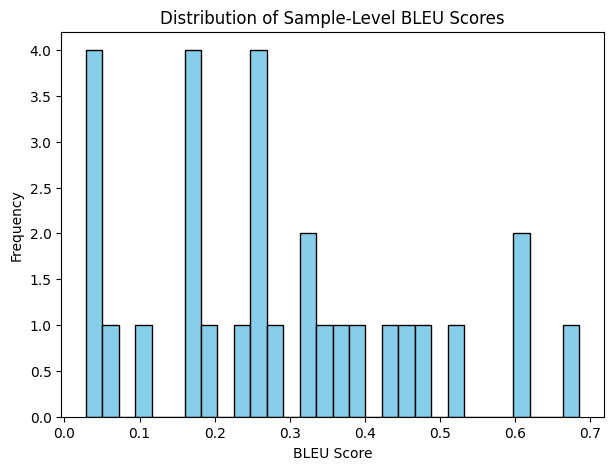

: 

In [13]:
# =============================================
# 7) Visualize the BLEU distribution
# =============================================
plt.figure(figsize=(7,5))
plt.hist(bleu_scores, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Sample-Level BLEU Scores")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.show()


NameError: name 'sns' is not defined

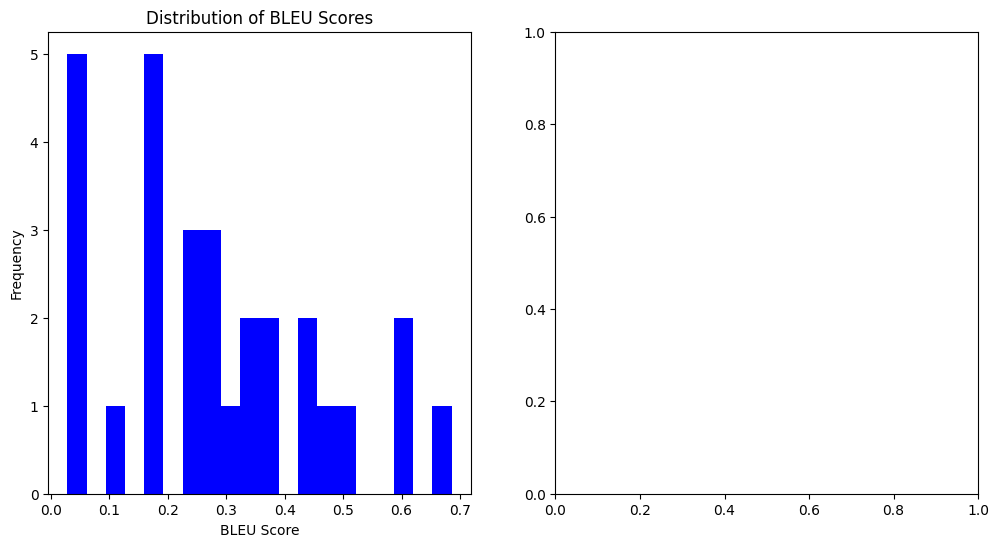

In [12]:
# =========================================
# 7) Visualization
# =========================================
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(bleu_scores, bins=20, color='blue')
plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
rouge_df = pd.DataFrame(rouge_scores)
for col in rouge_df.columns:
    sns.kdeplot(rouge_df[col], label=col)
plt.title('Distribution of ROUGE Scores')
plt.xlabel('Score')
plt.legend()

plt.tight_layout()
plt.show()